<a href="https://colab.research.google.com/github/2667schummr/recurrent-nn-cystic-fibrosis/blob/multi-layer-lstm/cf_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# Specify training parameters
device = '/device:GPU:0'
print_every = 100
batch_size = 100

In [0]:
# Make google drive files accessible
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks'
os.chdir(path)
print('Current Working Directory: {}'.format(os.getcwd()))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Current Working Directory: /content/gdrive/My Drive/Colab Notebooks


In [0]:
# Load the panda dataframe containing the features
feats = pd.read_pickle('./processed_data_complete_feats.pkl')
print('Feature Shape: {}'.format(feats.shape))

max_seq_length = feats.groupby('eDWID').count()['YRM'].max()

drop_cols = ['eDWID', 'YRM'] # These are identification columns
feats.head()

Feature Shape: (513452, 34)


,eDWID,YRM,mssa,mrsa,h_flu,pseudo,burkho_complex,alcalig,steno,enterobacter,serratia_marcescens,aspergillus,candida,scedosporium,mabscessus,mai,bd_age,sex,suff,trunc03,all_tob,all_mod,all_bd,dnase,inhcolistin,inhaztreonam,hypersaline,chronic_macrolide,oral_steroids,inh_steroids,inhsteroids_bronchodil,oral_other_abx,txflag,othertx
0,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0
1,900000702,2004,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
2,900000702,2005,0,0,0,1,0,0,0,0,0,1,0,0,0,0,8,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
3,900000702,2006,0,0,0,1,0,0,0,0,0,1,0,0,0,0,9,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0
4,900000702,2007,0,0,0,1,0,0,0,0,0,1,0,0,0,0,10,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0


In [0]:
# one-hot-encode trunc03 feature
feats = pd.get_dummies(feats, columns=['trunc03'])
num_feats = feats.shape[1] - 2
feats.head()

,eDWID,YRM,mssa,mrsa,h_flu,pseudo,burkho_complex,alcalig,steno,enterobacter,serratia_marcescens,aspergillus,candida,scedosporium,mabscessus,mai,bd_age,sex,suff,all_tob,all_mod,all_bd,dnase,inhcolistin,inhaztreonam,hypersaline,chronic_macrolide,oral_steroids,inh_steroids,inhsteroids_bronchodil,oral_other_abx,txflag,othertx,trunc03_0,trunc03_1,trunc03_2,trunc03_3,trunc03_4,trunc03_5
0,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,900000702,2004,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,900000702,2005,0,0,0,1,0,0,0,0,0,1,0,0,0,0,8,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,900000702,2006,0,0,0,1,0,0,0,0,0,1,0,0,0,0,9,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,900000702,2007,0,0,0,1,0,0,0,0,0,1,0,0,0,0,10,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0


In [0]:
# Load the pandas dataframe containing the labels
labels = pd.read_pickle('./dflags.pkl')
print('Labels Shape: {}'.format(labels.shape))
num_obs = labels.shape[0]
labels.head()

Labels Shape: (43454, 2)


,eDWID,dflag
0,900000702,0
99,900000736,0
106,900000742,1
196,900000776,0
200,900010702,1


In [0]:
# Define a class that generates batches of training and testing data
class Dataset(object):
    def __init__(self, labels, batch_size, shuffle=False):
        self.X = labels['eDWID'].as_matrix()
        self.y = labels['dflag'].as_matrix()
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
          np.random.shuffle(idxs)
        return iter((self.X[idxs[i:i+B]], self.y[idxs[i:i+B]]) for i in range(0, N, B))

In [0]:
# Split the data into training and testing sets and create Dataset objects 
# and oversample training data for class balance
labels = labels.sample(frac=1)
labels_train, labels_test = train_test_split(labels, test_size=0.2, shuffle=False)

ros = RandomOverSampler()
X, y = ros.fit_resample(labels_train['eDWID'].as_matrix().reshape((-1, 1)), 
                        labels_train['dflag'])
labels_train = pd.DataFrame({'eDWID': X.reshape((-1,)), 'dflag': y})

patient_batches_train = Dataset(labels_train, batch_size, shuffle=True)
patient_batches_test = Dataset(labels_test, batch_size, shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Means Deaths per Batch 0.5000310559006211



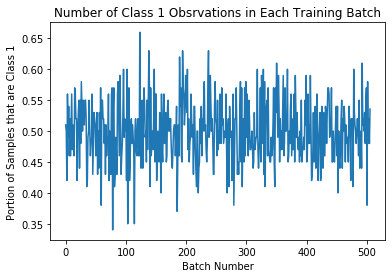

In [0]:
deaths_per_batch = []
batch_num = []
for i, (patients, patient_labels) in enumerate(patient_batches_train):
  deaths_per_batch.append(patient_labels.sum() / patient_labels.shape[0])
  batch_num.append(i)

plt.plot(batch_num, deaths_per_batch);
mean_deaths_per_batch = np.array(deaths_per_batch).mean()
print('Means Deaths per Batch {}\n'.format(mean_deaths_per_batch))
plt.title('Number of Class 1 Obsrvations in Each Training Batch');
plt.xlabel('Batch Number');
plt.ylabel('Portion of Samples that are Class 1');

In [0]:
# Method for computing testing accuracies 
def check_accuracy(sess, dset, x, scores, seq_mask, is_training=None):
    num_correct, num_samples = 0, 0
    num_pos, num_pos_correct = 0, 0
    num_neg, num_neg_correct = 0, 0

    for patients, patient_labels in dset:
      x_batch, y_batch, mask_batch = generate_data(patients, patient_labels)
      feed_dict = {x: x_batch, is_training: 0, seq_mask: mask_batch}

      scores_np = sess.run(scores, feed_dict=feed_dict)
      y_pred = scores_np.argmax(axis=1)

      num_samples += x_batch.shape[0]
      num_correct += (y_pred == y_batch).sum()

      num_pos += y_batch.sum()
      num_pos_correct += ((y_pred == y_batch) & (y_batch == 1)).sum()

      num_neg += y_batch.shape[0] - y_batch.sum()
      num_neg_correct += ((y_pred == y_batch) & (y_batch == 0)).sum()

    acc = float(num_correct) / num_samples
    prec = float(num_pos_correct) / num_pos
    true_neg_rate = float(num_neg_correct) / num_neg

    print('Accuracy: Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    print('Precision: Got {} / {} correct ({}%)'.format(num_pos_correct, num_pos, 100*prec))
    print('True Negative Rate: Got {} / {} correct ({}%)'.format(num_neg_correct, num_neg, 100*true_neg_rate))

In [0]:
# Method for transforming the pandas dataframes into 3-D tensors for the RNN
def generate_data(patients, patient_labels):
  X = np.zeros((batch_size, max_seq_length, num_feats))
  Y = np.zeros((batch_size))
  mask = np.zeros((batch_size, max_seq_length))

  for i, patient in enumerate(patients):
    patient_feats = feats[feats.eDWID == patient].drop(drop_cols, axis=1)
    patient_feats = patient_feats.as_matrix()
    seq_length = patient_feats.shape[0]
    X[i, :seq_length, :] = patient_feats
    mask[i, :seq_length] = True
    mask[i, seq_length:] = False 
    Y[i] = labels[labels.eDWID == patient]['dflag'].as_matrix()[0]
  
  return X, Y, mask

In [0]:
# The training procedure
def train(model_init_fn, optimizer_init_fn, num_epochs=1):
    tf.reset_default_graph()    

    x = tf.placeholder(tf.float32, [None,  max_seq_length, num_feats])
    y = tf.placeholder(tf.int32, [None])
    seq_mask = tf.placeholder(tf.bool, [None, max_seq_length])
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    scores = model_init_fn(x, is_training, seq_mask)

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
    loss = tf.reduce_mean(loss)

    optimizer = optimizer_init_fn()
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss)
      
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                            log_device_placement=False))
    with sess:
      sess.run(tf.global_variables_initializer())
      t = 0
      loss_history = []
      for epoch in range(num_epochs):
          print('Starting epoch %d' % epoch)
          for (patients, patient_labels) in patient_batches_train:
            x_np, y_np, mask_np = generate_data(patients, patient_labels)
            feed_dict = {x: x_np, y: y_np, is_training: 1, seq_mask: mask_np}
            score_np, loss_np, _ = sess.run([scores, loss, train_op], feed_dict=feed_dict)
            loss_history.append(loss_np)
            if t % print_every == 0:
              print('Iteration %d, loss = %.4f' % (t, loss_np))
              check_accuracy(sess, patient_batches_test, x, scores, seq_mask,
                             is_training=is_training)
              print()
            t += 1
      return loss_history
            

In [0]:
# Define the model and optimize and train the model
def model_init_fn(inputs, is_training, seq_filter):
    layers = [tf.keras.layers.LSTM(100,
                                   batch_input_shape=(None, max_seq_length, num_feats),
                                   return_sequences=True), 
              tf.keras.layers.LSTM(100, return_sequences=True),
              tf.keras.layers.LSTM(2, return_sequences=False)]
    model = tf.keras.Sequential(layers)

    return model(inputs, mask=seq_filter, training=is_training) 

learning_rate = 1e-3
def optimizer_init_fn():
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer

loss_history = train(model_init_fn, optimizer_init_fn, num_epochs=10)

Starting epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


Iteration 0, loss = 0.6943
Accuracy: Got 6051 / 8700 correct (69.55%)
Precision: Got 553 / 2365.0 correct (23.382663847780126%)
True Negative Rate: Got 5498 / 6335.0 correct (86.78768745067089%)

Iteration 100, loss = 0.4287
Accuracy: Got 7426 / 8700 correct (85.36%)
Precision: Got 1960 / 2365.0 correct (82.8752642706131%)
True Negative Rate: Got 5466 / 6335.0 correct (86.28255722178373%)

Iteration 200, loss = 0.4459
Accuracy: Got 7402 / 8700 correct (85.08%)
Precision: Got 2047 / 2365.0 correct (86.553911205074%)
True Negative Rate: Got 5355 / 6335.0 correct (84.5303867403315%)

Iteration 300, loss = 0.3992
Accuracy: Got 7158 / 8700 correct (82.28%)
Precision: Got 2179 / 2365.0 correct (92.1353065539112%)
True Negative Rate: Got 4979 / 6335.0 correct (78.59510655090766%)

Iteration 400, loss = 0.2923
Accuracy: Got 7444 / 8700 correct (85.56%)
Precision: Got 2098 / 2365.0 correct (88.71035940803382%)
True Negative Rate: Got 5346 / 6335.0 correct (84.38831886345699%)

Iteration 500, lo

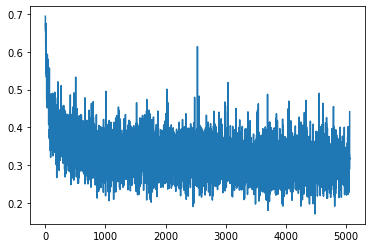

In [0]:
plt.plot(range(len(loss_history)), loss_history);